# Imports

In [4]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import pickle 
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from scipy.sparse import coo_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.svm import SVC

from sklearn.metrics import f1_score,recall_score, precision_score

import ast

import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')

%matplotlib inline

# Path and Load Data 

In [5]:
data = pd.read_csv('magazine_[actual_size=4954]_processed_merge.csv').magazine
data = pd.DataFrame(data=data)
data.head() 

,magazine
0,"['word', 'street', 'theflightattend', 'preflig..."
1,"[""kathieleegifford'"", 'daughter', 'cassidi', '..."
2,"['internet', 'troll', 'field', 'day', ""jadensm..."
3,"['star', 'know', 'stay', 'spotlight', 'see', '..."
4,"['relationship', 'rock', 'caseyaffleck', 'gf',..."


In [6]:
INTEREST_positive_tweets = data[:4968] 
print('INTEREST tweets size :', len(INTEREST_positive_tweets))
INTEREST_negative_tweets = data[4968:] 
print('non-INTEREST tweets size :', len(INTEREST_negative_tweets))

INTEREST tweets size : 4968
non-INTEREST tweets size : 4986


* Train test split: 20% will be in the test set, and 80% in the training set.


In [7]:
# split the data into two pieces, one for training and one for testing (validation set) 
test_pos = INTEREST_positive_tweets[4000:]
train_pos = INTEREST_positive_tweets[:4000]

test_neg = INTEREST_negative_tweets[4000:]
train_neg = INTEREST_negative_tweets[:4000]

In [8]:
train_x = pd.concat([train_pos, train_neg], axis=0) 
test_x = pd.concat([test_pos, test_neg], axis=0)

- Create the numpy array of positive labels and negative labels.

In [9]:
# combine positive and negative labels
train_y = np.append(np.ones((len(train_pos), 1)), np.zeros((len(train_neg), 1)), axis=0)
test_y = np.append(np.ones((len(test_pos), 1)), np.zeros((len(test_neg), 1)), axis=0)

In [10]:
print('train shape:', train_y.shape)
print('test shape:', test_y.shape)

train shape: (8000, 1)
test shape: (1954, 1)


# Vocabulary for Politics Dataset 

In [11]:
def generate_tweets_list(dataframe_single):
    train_x_arr = [] 
    for index, row in dataframe_single.iterrows(): 
        for a in row.values: 
            train_x_arr.append(ast.literal_eval(a))
            
    return train_x_arr

In [12]:
train_x_arr = generate_tweets_list(train_x)

In [13]:
def build_freqs(train_x, train_y):
    
    yslist = np.squeeze(train_y).tolist()
    
    freqs = {}
    for y, tweet in zip(yslist, train_x):
        for word in tweet:
            pair = (word, y)
            if pair in freqs:
                freqs[pair] += 1
            else:
                freqs[pair] = 1

    return freqs

In [14]:
freqs = build_freqs(train_x_arr, train_y) 
train_x_arr = generate_tweets_list(train_x)

In [15]:
len(freqs)

15171

In [16]:
freqs_vis = np.ndarray((1,2))

for (word, label), value in freqs.items(): 
    if label == 1.0: 
        freqs_vis = np.append(freqs_vis, [[word, value]], axis=0)

        
freqs_vis

array([['0.0', '0.0'],
       ['word', '15'],
       ['street', '6'],
       ...,
       ['milliped', '1'],
       ['creepy-crawl', '1'],
       ['mayr', '1']], dtype='<U32')

In [17]:
freqs_vis = np.delete(freqs_vis, 0, axis=0)

In [18]:
freqs_vis = pd.DataFrame(data=freqs_vis, columns=['word', 'frequency'])
freqs_vis.head()

,word,frequency
0,word,15
1,street,6
2,theflightattend,7
3,preflight,1
4,loung,2


In [19]:
freqs_vis['frequency'] = freqs_vis['frequency'].astype('int')
freqs_vis = freqs_vis.nlargest(columns='frequency', n=20).iloc[2:,:]
freqs_vis

,word,frequency
40,star,278
177,new,278
114,...,241
231,—,221
1564,imag,209
1853,📸,208
37,say,206
6694,getti,204
99,get,201
18,look,183


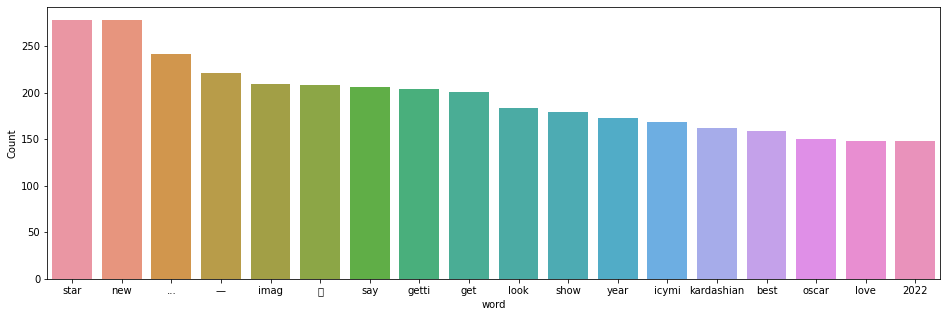

In [20]:
plt.figure(figsize=(16,5)) 
ax = sns.barplot(data=freqs_vis, x='word', y='frequency')
ax.set(ylabel = 'Count') 
plt.show() 

## Extract Features 
* Given a list of tweets, extract the features and store them in a matrix. Extract two features.
    * The first feature is the number of positive words in a tweet.
    * The second feature is the number of negative words in a tweet. 
* Then train the logistic regression classifier on these features.
* Test the classifier on a validation set. 

In [21]:
def extract_features(tweet, freqs):
    '''
    Input: 
        tweet: a list of words for one tweet 
        freqs: a dictionary corresponding to the frequencies of each tuple 
    Output:
        x: a feature vector of dimension (1, 3)
    '''
    x = np.zeros((1, 3)) 
    x[0,0] = 1 # bias term  
    
    for word in tweet: 
        
        x[0,1] += freqs.get((word, 1.0), 0) 
        
        x[0,2] += freqs.get((word, 0.0), 0) 
        
    assert(x.shape == (1, 3))
    return x 

In [22]:
# Ex 
train_x_arr[0]

['word',
 'street',
 'theflightattend',
 'preflight',
 'loung',
 'place',
 'see',
 'pic',
 'coltonunderwood',
 'oliviaculpo',
 'ball',
 'exclus',
 'coachella',
 'affair']

In [23]:
extract_features(train_x_arr[0], freqs)

array([[  1., 373., 113.]])

In [24]:
extract_features(['asd', 'asd', 'asd'], freqs)

array([[1., 0., 0.]])

In [25]:
X = np.zeros((len(train_x_arr), 3))
for i in range(len(train_x_arr)):
    X[i, :]= extract_features(train_x_arr[i], freqs) 
    
X[:5]

array([[  1., 373., 113.],
       [  1., 830., 574.],
       [  1., 651., 441.],
       [  1., 683., 373.],
       [  1., 265.,  46.]])

In [26]:
y = train_y

In [27]:
X_sparse = coo_matrix(X)
X, X_sparse, y = shuffle(X, X_sparse, y, random_state=0)

y

array([[1.],
       [1.],
       [0.],
       ...,
       [1.],
       [1.],
       [1.]])

In [28]:
X

array([[  1., 470., 252.],
       [  1., 263., 129.],
       [  1., 534., 583.],
       ...,
       [  1., 170., 205.],
       [  1., 288., 160.],
       [  1., 591., 401.]])

In [29]:
vis_X = pd.DataFrame(data=X, columns=['bias', 'positive', 'negative'])
vis_y = pd.DataFrame(data=y, columns=['target']) 

vis_data = pd.concat([vis_X, vis_y], axis=1) 

vis_data.head() 

,bias,positive,negative,target
0,1.0,470.0,252.0,1.0
1,1.0,263.0,129.0,1.0
2,1.0,534.0,583.0,0.0
3,1.0,1229.0,737.0,1.0
4,1.0,716.0,23.0,1.0


<Figure size 720x720 with 0 Axes>

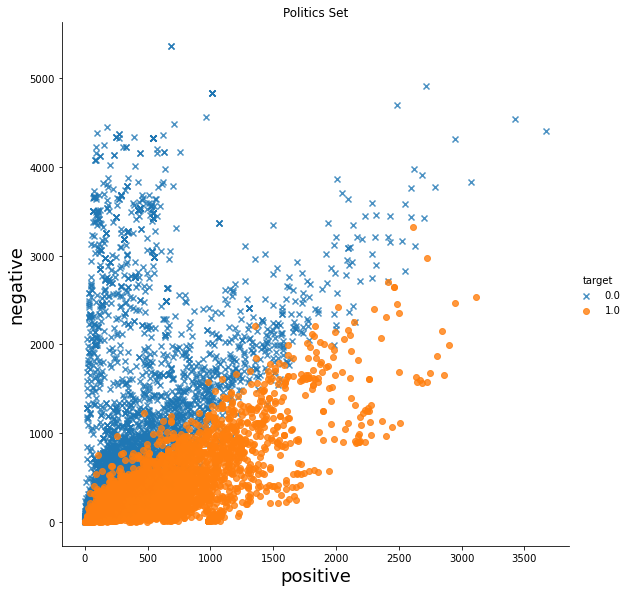

In [30]:
plt.figure(figsize=(10,10))
#plt.scatter(x='positive', y='negative', data=vis_data, c=vis_data.target, alpha=0.8, cmap='viridis', s=15)
sns.lmplot(x='positive', y='negative', data=vis_data, hue='target', fit_reg=False, height=8, markers=['x','o'])
plt.title('Politics Set')
plt.xlabel('positive', fontsize=18)
plt.ylabel('negative', fontsize=18) 
plt.show() 

# Classifier  1 : Logistic Regression 

* The sigmoid function is defined as: 

$$ h(z) = \frac{1}{1+\exp^{-z}} $$

It maps the input 'z' to a value that ranges between 0 and 1, and so it can be treated as a probability. 


# 1.1 Apply Logistic Regression and Cross - Validation 

* As a reminder, We have a balanced dataset. 

In [31]:
cross_val_score(LogisticRegression(), X, y.ravel())

array([0.89125 , 0.884375, 0.891875, 0.895   , 0.883125])

- We have very satisfying results. Let's do some hyper-parameter tuning.

# 1.2 Grid Search on Logistic Regression

In [32]:
%%time
gs_model = LogisticRegression(solver='liblinear') 
space = {
    'C': [1e-10,1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10, 100]
}

search = GridSearchCV(gs_model, space, scoring='accuracy', cv = 5) 
search.fit(X, y.ravel())  

CPU times: total: 812 ms
Wall time: 296 ms


GridSearchCV(cv=5, estimator=LogisticRegression(solver='liblinear'),
             param_grid={'C': [1e-10, 1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10,
                               100]},
             scoring='accuracy')

In [33]:
print('Best Score: %s' % search.best_score_)
print('Best Hyperparameters: %s' % search.best_params_)

Best Score: 0.888625
Best Hyperparameters: {'C': 0.001}


In [34]:
pd.DataFrame(search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.005179,0.002904,0.000598,0.000488,0.0,{'C': 1e-10},0.63625,0.655000,0.648750,0.653125,0.652500,0.649125,0.006750,9
1,0.004787,0.000399,0.000399,0.000488,0.00001,{'C': 1e-05},0.89125,0.884375,0.891875,0.893125,0.880625,0.888250,0.004880,8
2,0.006981,0.001261,0.000599,0.000489,0.0001,{'C': 0.0001},0.89125,0.884375,0.891875,0.893125,0.881875,0.888500,0.004500,7
3,0.006979,0.002185,0.001204,0.000396,0.001,{'C': 0.001},0.89125,0.884375,0.891875,0.893125,0.882500,0.888625,0.004319,1
4,0.006892,0.001195,0.000676,0.000569,0.01,{'C': 0.01},0.89125,0.884375,0.891875,0.893125,0.882500,0.888625,0.004319,1
5,0.004591,0.000481,0.000399,0.000489,0.1,{'C': 0.1},0.89125,0.884375,0.891875,0.893125,0.882500,0.888625,0.004319,1
6,0.004824,0.000424,0.000200,0.000399,1,{'C': 1},0.89125,0.884375,0.891875,0.893125,0.882500,0.888625,0.004319,1
7,0.004394,0.000486,0.000396,0.000485,10,{'C': 10},0.89125,0.884375,0.891875,0.893125,0.882500,0.888625,0.004319,1
8,0.004619,0.000455,0.000397,0.000487,100,{'C': 100},0.89125,0.884375,0.891875,0.893125,0.882500,0.888625,0.004319,1


In [35]:
search.best_score_

0.888625

In [36]:
search.best_estimator_

LogisticRegression(C=0.001, solver='liblinear')

# Test Logistic Regression Model

In [37]:
test_x_arr = generate_tweets_list(test_x)

In [38]:
X_test = np.zeros((len(test_x_arr), 3))
for i in range(len(test_x_arr)):
    X_test[i, :]= extract_features(test_x_arr[i], freqs) 
    
X_test[:5]

array([[  1., 362., 165.],
       [  1., 468.,  47.],
       [  1., 625., 431.],
       [  1., 144.,  86.],
       [  1., 470., 275.]])

In [39]:
search.best_estimator_.score(X_test, test_y.ravel())

0.7737973387922211

In [40]:
y_hat = search.best_estimator_.predict(X_test)
print("F1-Score is", f1_score(test_y.ravel(), y_hat))

F1-Score is 0.790521327014218


In [41]:
y_hat = search.best_estimator_.predict(X_test)
print("Precision is", precision_score(test_y.ravel(), y_hat))

Precision is 0.7302977232924693


In [42]:
y_hat = search.best_estimator_.predict(X_test)
print("Recall is", recall_score(test_y.ravel(), y_hat))

Recall is 0.8615702479338843


# Classifier 2 : SVM 

In [43]:
clf_svm = SVC(kernel='linear') 
clf_svm.fit(X, y.ravel())

SVC(kernel='linear')

In [44]:
clf_svm.score(X_test, test_y.ravel())

0.7830092118730808

In [45]:
clf_svm.score(X, y.ravel())

0.89

In [46]:
clf_svm.coef0

0.0

In [47]:
clf_svm.coef_

array([[ 1.98951966e-11,  1.15683990e-02, -9.91213042e-03]])

# 2.1 Cross-Validation on Simple SVM Model 

In [48]:
cross_val_score(SVC(kernel='linear'), X, y.ravel(), cv=5)

array([0.89125 , 0.884375, 0.890625, 0.89375 , 0.883125])

# 2.2 SVM Grid Search on Linear Kernel 

In [49]:
param_grid = {
    'C' : [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0], 
    'kernel' : ['linear']
}

grid_svm_linear = GridSearchCV(SVC(), param_grid, refit=3, verbose=3, cv=5)
grid_svm_linear.fit(X, y.ravel())

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV 1/5] END ............C=1e-05, kernel=linear;, score=0.891 total time=   0.7s
[CV 2/5] END ............C=1e-05, kernel=linear;, score=0.886 total time=   0.9s
[CV 3/5] END ............C=1e-05, kernel=linear;, score=0.889 total time=   0.6s
[CV 4/5] END ............C=1e-05, kernel=linear;, score=0.894 total time=   0.6s
[CV 5/5] END ............C=1e-05, kernel=linear;, score=0.882 total time=   0.6s
[CV 1/5] END ...........C=0.0001, kernel=linear;, score=0.891 total time=   0.9s
[CV 2/5] END ...........C=0.0001, kernel=linear;, score=0.885 total time=   0.8s
[CV 3/5] END ...........C=0.0001, kernel=linear;, score=0.891 total time=   0.9s
[CV 4/5] END ...........C=0.0001, kernel=linear;, score=0.896 total time=   0.9s
[CV 5/5] END ...........C=0.0001, kernel=linear;, score=0.882 total time=   0.8s
[CV 1/5] END ............C=0.001, kernel=linear;, score=0.892 total time=   2.0s
[CV 2/5] END ............C=0.001, kernel=linear;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1.0],
                         'kernel': ['linear']},
             refit=3, verbose=3)

In [50]:
grid_svm_linear.best_score_

0.88925

In [51]:
grid_svm_linear.best_estimator_

SVC(C=0.001, kernel='linear')

In [52]:
grid_svm_linear.best_estimator_.score(X_test, test_y.ravel())

0.7865916069600819

In [53]:
f1_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.7940740740740742

In [54]:
recall_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.760643330179754

In [55]:
precision_score(grid_svm_linear.best_estimator_.predict(X_test), test_y.ravel())

0.8305785123966942

In [99]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.790521327014218 ,
        'precision':0.7302977232924693 , 
        'recall': 0.8615702479338843,
        'test accuracy' :0.7737973387922211,
        'validation accuracy': 0.888625  
    },
    
    'Linear SVM': {
        'f1 score': 0.7940740740740742, 
        'precision':0.8305785123966942, 
        'recall':0.760643330179754 ,
        'test accuracy':  0.7865916069600819 ,
        'validation accuracy':  0.88925
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM
f1 score,0.790521,0.794074
precision,0.730298,0.830579
recall,0.861570,0.760643
test accuracy,0.773797,0.786592
validation accuracy,0.888625,0.889250


# 2.3 Grid Search on SVM RBF Kernel 

In [57]:
%%time
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}
 
grid_svm_rbf = GridSearchCV(SVC(), param_grid, refit = True, verbose = 3)
 
grid_svm_rbf.fit(X, y.ravel())

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.515 total time=   4.7s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.535 total time=   4.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.516 total time=   4.4s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.521 total time=   4.4s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.513 total time=   4.5s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.517 total time=   4.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.546 total time=   4.7s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.516 total time=   4.6s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.516 total time=   5.0s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.519 total time=   4.7s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.606 total time=   4.4s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.576 total time=   4.6s
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.571 total time=   4.6s
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.569 total time=   4.5s
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.562 total time=   4.5s
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.659 total time=   4.8s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.658 total time=   4.6s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.657 total time=   4.5s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.650 total time=   4.8s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.667 total time=   4.5s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.776 total time=   5.5s
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.774 total time=   5.4s
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.768 total time=   6.6s
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [58]:
grid_svm_rbf.best_score_

0.8873749999999999

In [59]:
grid_svm_rbf.best_estimator_.score(X_test, test_y.ravel())

0.7804503582395087

In [60]:
f1_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7916464303059738

In [61]:
precision_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.8419421487603306

In [62]:
recall_score(grid_svm_rbf.best_estimator_.predict(X_test), test_y.ravel())

0.7470210815765352

In [101]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.790521327014218 ,
        'precision':0.7302977232924693 , 
        'recall': 0.8615702479338843,
        'test accuracy' :0.7737973387922211,
        'validation accuracy': 0.888625  
    },
    
    'Linear SVM': {
        'f1 score': 0.7940740740740742, 
        'precision':0.8305785123966942, 
        'recall':0.760643330179754 ,
        'test accuracy':  0.7865916069600819 ,
        'validation accuracy':  0.88925
    },
    
    'RBF SVM' : {
        'f1 score': 0.7916464303059738, 
        'precision': 0.8419421487603306,
        'recall': 0.7470210815765352,
        'test accuracy': 0.7804503582395087,
        'validation accuracy': 0.8873749999999999
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM
f1 score,0.790521,0.794074,0.791646
precision,0.730298,0.830579,0.841942
recall,0.861570,0.760643,0.747021
test accuracy,0.773797,0.786592,0.780450
validation accuracy,0.888625,0.889250,0.887375


# 3. Naive Bayes Classifier 

In [64]:
def count_tweets(tweets, ys):
    '''
    Input:
        tweets: a list of tweets
        ys: a list corresponding to the sentiment of each tweet (either 0 or 1)
    Output:
        result: a dictionary mapping each pair to its frequency
    '''
    result = dict() 
    
    for y, tweet in zip(ys, tweets):
        for word in tweet:
          
            pair = (word,y)
            # if the key exists in the dictionary, increment the count
            if pair in result:
                result[pair] += 1
            # else, if the key is new, add it to the dictionary and set the count to 1
            else:
                result[pair] = 1
   
    return result

In [65]:
freqs = count_tweets(train_x_arr, train_y.squeeze())

In [66]:
freqs

{('word', 1.0): 15,
 ('street', 1.0): 6,
 ('theflightattend', 1.0): 7,
 ('preflight', 1.0): 1,
 ('loung', 1.0): 2,
 ('place', 1.0): 15,
 ('see', 1.0): 133,
 ('pic', 1.0): 30,
 ('coltonunderwood', 1.0): 2,
 ('oliviaculpo', 1.0): 1,
 ('ball', 1.0): 3,
 ('exclus', 1.0): 104,
 ('coachella', 1.0): 47,
 ('affair', 1.0): 7,
 ("kathieleegifford'", 1.0): 1,
 ('daughter', 1.0): 87,
 ('cassidi', 1.0): 1,
 ('take', 1.0): 85,
 ('look', 1.0): 183,
 ('insid', 1.0): 35,
 ('life', 1.0): 85,
 ('model', 1.0): 24,
 ('friendship', 1.0): 21,
 ('famou', 1.0): 23,
 ('pal', 1.0): 16,
 ('like', 1.0): 107,
 ('kardashian', 1.0): 162,
 ('internet', 1.0): 6,
 ('troll', 1.0): 9,
 ('field', 1.0): 6,
 ('day', 1.0): 103,
 ("jadensmith'", 1.0): 1,
 ('expens', 1.0): 5,
 ("willsmith'", 1.0): 17,
 ('son', 1.0): 71,
 ('butt', 1.0): 3,
 ('joke', 1.0): 43,
 ('say', 1.0): 206,
 ('talk', 1.0): 70,
 ('topic', 1.0): 4,
 ('star', 1.0): 278,
 ('know', 1.0): 100,
 ('stay', 1.0): 18,
 ('spotlight', 1.0): 6,
 ('jenniferlopez', 1.0): 2

In [67]:
def lookup(freqs, word, label):
    n = 0  # freqs.get((word, label), 0)

    pair = (word, label)
    if (pair in freqs):
        n = freqs[pair]

    return n

In [68]:
def train_naive_bayes(freqs, train_x, train_y):
    '''
    Output:
        logprior: the log prior. (equation 3 above)
        loglikelihood: the log likelihood of you Naive bayes equation. (equation 6 above)
    '''
    loglikelihood = {}
    logprior = 0

    # calculate V, the number of unique words in the vocabulary
    vocab = set([pair[0] for pair in freqs.keys()])
    V = len(vocab)

    # calculate N_pos and N_neg
    N_pos = N_neg = 0
    for pair in freqs.keys():
        # if the label is positive (greater than zero)
        if pair[1] > 0:

            # Increment the number of positive words by the count for this (word, label) pair
            N_pos += freqs[pair]

        # else, the label is negative
        else:

            # increment the number of negative words by the count for this (word,label) pair
            N_neg += freqs[pair]

    # Calculate D, the number of documents
    D = len(train_y)

    # Calculate D_pos, the number of positive documents (*hint: use sum(<np_array>))
    D_pos = (len(list(filter(lambda x: x > 0, train_y))))

    # Calculate D_neg, the number of negative documents (*hint: compute using D and D_pos)
    D_neg = (len(list(filter(lambda x: x <= 0, train_y))))

    # Calculate logprior
    logprior = np.log(D_pos) - np.log(D_neg)

    # For each word in the vocabulary...
    for word in vocab:
        # get the positive and negative frequency of the word
        freq_pos = lookup(freqs,word,1)
        freq_neg = lookup(freqs,word,0)

        # calculate the probability that each word is positive, and negative
        p_w_pos = (freq_pos + 1) / (N_pos + V)
        p_w_neg = (freq_neg + 1) / (N_neg + V)

        # calculate the log likelihood of the word
        loglikelihood[word] = np.log(p_w_pos/p_w_neg)

    return logprior, loglikelihood

In [69]:
logprior, loglikelihood = train_naive_bayes(freqs=freqs, train_x=train_x_arr, train_y=train_y.squeeze())

In [70]:
logprior

0.0

In [71]:
loglikelihood

{'timelin': 1.6764184589124516,
 'shipka': 1.2345857066334123,
 'multipl': -0.18944898246932526,
 'dwt': 3.2270158713236183,
 'franksinatra': 0.829120598525248,
 'nathali': 0.829120598525248,
 'child': 0.6782977087906643,
 'room': 0.2537564536216861,
 'touchdown': 0.829120598525248,
 'kebab': -0.5571737625946426,
 'invit': 0.541438526073467,
 'antagon': 0.1359734179653027,
 'wrath': 0.829120598525248,
 'disput': -0.5571737625946426,
 'knicks-net': -0.5571737625946426,
 'ski': 0.829120598525248,
 'sequin': 0.829120598525248,
 '—': 0.5347044938921229,
 'straw': 1.2345857066334123,
 'intens': 1.0522641498394578,
 'aromat': -1.4734644944687978,
 'dick': -0.9626388707028071,
 'rothaniel': 0.829120598525248,
 'pregnanc': 2.620880067753303,
 'poppi': -0.5571737625946426,
 'club': -3.1497110765750085,
 'overtim': -1.2503209431545879,
 'sock': 1.2345857066334123,
 '28': -0.9626388707028071,
 'crackdown': -0.5571737625946426,
 'ji-min': 0.829120598525248,
 "kyliejenner'": 1.5222677790851933,
 'g

## p = logprior + sum_i(loglikelihood_i)

In [72]:
def naive_bayes_predict(tweet, logprior, loglikelihood):
    '''
    Input:
        tweet: a processed tweet
        logprior: a number
        loglikelihood: a dictionary of words mapping to numbers
    Output:
        p: the sum of all the logliklihoods of each word in the tweet (if found in the dictionary) + logprior (a number)

    '''
    p = 0
    # add the logprior
    p += logprior

    for word in tweet:

        # check if the word exists in the loglikelihood dictionary
        if word in loglikelihood:
            # add the log likelihood of that word to the probability
            p += loglikelihood[word]

    return p

In [73]:
tweet = train_x_arr[0]
p = naive_bayes_predict(tweet, logprior, loglikelihood) 
p

17.141460055112688

In [74]:
def test_naive_bayes(test_x, test_y, logprior, loglikelihood):
    """
    Output:
        accuracy: (# of tweets classified correctly)/(total # of tweets)
    """
    accuracy = 0  

    y_hats = []
    for tweet in test_x:
        # if the prediction is > 0
        if naive_bayes_predict(tweet, logprior, loglikelihood) > 0:
            # the predicted class is 1
            y_hat_i = 1
        else:
            # otherwise the predicted class is 0
            y_hat_i = 0

        y_hats.append(y_hat_i)

    error = np.mean(np.absolute(y_hats-test_y))
    accuracy = 1-error
    
    return accuracy

In [75]:
test_naive_bayes(test_x_arr, test_y.squeeze(), logprior, loglikelihood) 

0.8556806550665301

In [76]:
test_naive_bayes(train_x_arr, np.squeeze(train_y), logprior, loglikelihood)

0.972

In [77]:
y_hats =[naive_bayes_predict(item, logprior, loglikelihood) > 0 if 1 else 0 for item in test_x_arr]

In [78]:
f1_score(np.squeeze(test_y), y_hats)

0.8681010289990645

In [79]:
precision_score(np.squeeze(test_y), y_hats)

0.7931623931623931

In [80]:
recall_score(np.squeeze(test_y), y_hats)

0.9586776859504132

In [102]:
result = {
    'Logistic Regression': {
        'f1 score' : 0.790521327014218 ,
        'precision':0.7302977232924693 , 
        'recall': 0.8615702479338843,
        'test accuracy' :0.7737973387922211,
        'validation accuracy': 0.888625  
    },
    
    'Linear SVM': {
        'f1 score': 0.7940740740740742, 
        'precision':0.8305785123966942, 
        'recall':0.760643330179754 ,
        'test accuracy':  0.7865916069600819 ,
        'validation accuracy':  0.88925
    },
    
    'RBF SVM' : {
        'f1 score': 0.7916464303059738, 
        'precision': 0.8419421487603306,
        'recall': 0.7470210815765352,
        'test accuracy': 0.7804503582395087,
        'validation accuracy': 0.8873749999999999
    },
    
    'Naive Bayes' : {
        'f1 score': 0.8681010289990645, 
        'precision':0.7931623931623931, 
        'recall': 0.9586776859504132,
        'test accuracy': 0.8556806550665301,
        'validation accuracy': 0.972
    }
}

pd.DataFrame(result)

,Logistic Regression,Linear SVM,RBF SVM,Naive Bayes
f1 score,0.790521,0.794074,0.791646,0.868101
precision,0.730298,0.830579,0.841942,0.793162
recall,0.861570,0.760643,0.747021,0.958678
test accuracy,0.773797,0.786592,0.780450,0.855681
validation accuracy,0.888625,0.889250,0.887375,0.972000


# Implemenet Naive Bayes With Sklearn 

In [82]:
from sklearn.naive_bayes import MultinomialNB

In [83]:
train_x_non_array = [' '.join(item) for item in train_x_arr] 
train_x_non_array[:5] 

['word street theflightattend preflight loung place see pic coltonunderwood oliviaculpo ball exclus coachella affair',
 "kathieleegifford' daughter cassidi take look insid life model friendship famou pal like kardashian",
 "internet troll field day jadensmith' expens willsmith' son butt joke say like talk topic",
 'star know stay spotlight see jenniferlopez nicolekidman angelinajoli still grab headlin steal heart',
 'relationship rock caseyaffleck gf cayleecowan bicker lot bennif heat']

In [84]:
from sklearn.feature_extraction.text import CountVectorizer

In [85]:
vectorizer = CountVectorizer() 

In [86]:
vectorizer.fit(train_x_non_array)

CountVectorizer()

In [87]:
train_x_for_naivebayes = vectorizer.transform(train_x_non_array)

In [88]:
len(train_x_arr)

8000

In [89]:
len(vectorizer.vocabulary_)

10732

In [90]:
classifier_nb = MultinomialNB()

In [91]:
classifier_nb.fit(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

MultinomialNB()

In [92]:
classifier_nb.score(train_x_for_naivebayes.toarray(), np.squeeze(train_y))

0.96575

In [93]:
test_x_non_array = [' '.join(item) for item in test_x_arr] 
test_x_non_array[:5]

['meghan markl fan hail return pre-duchess style invictu game',
 'kim kardashian wish kourtney happi birthday twin swimsuit snap',
 'princess charlen share first famili photo sinc almost die ill',
 "kati maloney can't blame lala kent cut tie tom schwartz",
 'kendrick lamar announc new album mr moral big stepper']

In [94]:
text_x_vectorized = vectorizer.transform(test_x_non_array)

In [95]:
classifier_nb.score(text_x_vectorized, np.squeeze(test_y))

0.8515864892528148

In [96]:
model_nb = (logprior, loglikelihood)

In [97]:
logprior

0.0

In [98]:
loglikelihood

{'timelin': 1.6764184589124516,
 'shipka': 1.2345857066334123,
 'multipl': -0.18944898246932526,
 'dwt': 3.2270158713236183,
 'franksinatra': 0.829120598525248,
 'nathali': 0.829120598525248,
 'child': 0.6782977087906643,
 'room': 0.2537564536216861,
 'touchdown': 0.829120598525248,
 'kebab': -0.5571737625946426,
 'invit': 0.541438526073467,
 'antagon': 0.1359734179653027,
 'wrath': 0.829120598525248,
 'disput': -0.5571737625946426,
 'knicks-net': -0.5571737625946426,
 'ski': 0.829120598525248,
 'sequin': 0.829120598525248,
 '—': 0.5347044938921229,
 'straw': 1.2345857066334123,
 'intens': 1.0522641498394578,
 'aromat': -1.4734644944687978,
 'dick': -0.9626388707028071,
 'rothaniel': 0.829120598525248,
 'pregnanc': 2.620880067753303,
 'poppi': -0.5571737625946426,
 'club': -3.1497110765750085,
 'overtim': -1.2503209431545879,
 'sock': 1.2345857066334123,
 '28': -0.9626388707028071,
 'crackdown': -0.5571737625946426,
 'ji-min': 0.829120598525248,
 "kyliejenner'": 1.5222677790851933,
 'g

# Save The Best Model 

## Pickle 

It allows you to serialize your python object into a file.

In [110]:
with open('magazine_naivebayes.', 'wb') as f: 
    pickle.dump(model_nb, f)

In [111]:
with open('magazine_naivebayes.', 'rb') as f: 
    model_pickle = pickle.load(f)

In [105]:
type(model_pickle)

tuple

In [106]:
logprior, loglikel = model_pickle

In [107]:
loglikel

{'timelin': 1.6764184589124516,
 'shipka': 1.2345857066334123,
 'multipl': -0.18944898246932526,
 'dwt': 3.2270158713236183,
 'franksinatra': 0.829120598525248,
 'nathali': 0.829120598525248,
 'child': 0.6782977087906643,
 'room': 0.2537564536216861,
 'touchdown': 0.829120598525248,
 'kebab': -0.5571737625946426,
 'invit': 0.541438526073467,
 'antagon': 0.1359734179653027,
 'wrath': 0.829120598525248,
 'disput': -0.5571737625946426,
 'knicks-net': -0.5571737625946426,
 'ski': 0.829120598525248,
 'sequin': 0.829120598525248,
 '—': 0.5347044938921229,
 'straw': 1.2345857066334123,
 'intens': 1.0522641498394578,
 'aromat': -1.4734644944687978,
 'dick': -0.9626388707028071,
 'rothaniel': 0.829120598525248,
 'pregnanc': 2.620880067753303,
 'poppi': -0.5571737625946426,
 'club': -3.1497110765750085,
 'overtim': -1.2503209431545879,
 'sock': 1.2345857066334123,
 '28': -0.9626388707028071,
 'crackdown': -0.5571737625946426,
 'ji-min': 0.829120598525248,
 "kyliejenner'": 1.5222677790851933,
 'g

In [109]:
logprior

0.0